In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
import validate
from sklearn.preprocessing import StandardScaler
import PR_curve
import librosa as lb
import os
import matplotlib.pyplot as plt
import glob
import wave
import IPython
from IPython.display import display
import datetime

In [2]:
data_dir='filtered_csv_label'
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

In [3]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]
def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['z']==1)&(df['original']<df['leq']), 'z']=0
    return df

In [4]:
df_list=[]
for i in set(df['day']):
    lag=[] 
    window=5
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window))
    lag.append(df.loc[df['day']==i, ['day']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df['d']=0
df['z']=0
df

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            53.6           53.2           52.8           52.8           53.4   
1            54.0           53.6           53.2           52.8           52.8   
2            54.7           54.0           53.6           53.2           52.8   
3            55.7           54.7           54.0           53.6           53.2   
4            55.5           55.7           54.7           54.0           53.6   
...           ...            ...            ...            ...            ...   
3995305      45.9           45.6           45.4           45.9           46.0   
3995306      45.6           45.9           45.6           45.4           45.9   
3995307      45.8           45.6           45.9           45.6           45.4   
3995308      45.7           45.8           45.6           45.9           45.6   
3995309      45.9           45.7           45.8           45.6           45.9   

         day  d  z  
0          0  0  0  
1          0  0  0  
2          0  0  0  
3          0  0  0  
4          0  0  0  
...      ... .. ..  
3995305    9  0  0  
3995306    9  0  0  
3995307    9  0  0  
3995308    9  0  0  
3995309    9  0  0  

[3995310 rows x 8 columns]

In [5]:
test_day=[9]
train=df[(~df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)
test=df[(df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)
test

original  original_lag1  original_lag2  original_lag3  original_lag4
0           46.5           47.0           47.1           47.4           47.7
1           46.2           46.5           47.0           47.1           47.4
2           45.8           46.2           46.5           47.0           47.1
3           46.0           45.8           46.2           46.5           47.0
4           46.2           46.0           45.8           46.2           46.5
...          ...            ...            ...            ...            ...
413976      45.9           45.6           45.4           45.9           46.0
413977      45.6           45.9           45.6           45.4           45.9
413978      45.8           45.6           45.9           45.6           45.4
413979      45.7           45.8           45.6           45.9           45.6
413980      45.9           45.7           45.8           45.6           45.9

[413981 rows x 5 columns]

In [6]:
nk = 21
neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train)
d = neigh.kneighbors(test)[0]

d = np.mean(d, axis=1)
mx = np.max(d)
d = d / mx

In [7]:
test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
test_v['d']=d[0]
test_v.loc[window-1:, 'd']=d
d=test_v['d'].values

# 異常と判定したが教師異常ラベルがついてない音を抜き出す

## 評価

In [8]:
thr_df=pd.DataFrame({'day':[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                     'thr':[0.19946808510638298,0.23138297872340424 ,0.1276595744680851 ,0.26 ,0.14627659574468085 ,0.23138297872340424 ,0.2074468085106383 ,0.09574468085106383 ,0.1595744680851064, 0.18085106382978722 ]})
thr_df

day       thr
0    0  0.199468
1    1  0.231383
2    2  0.127660
3    3  0.260000
4    4  0.146277
5    5  0.231383
6    6  0.207447
7    7  0.095745
8    8  0.159574
9    9  0.180851

In [9]:
thr=float(thr_df.loc[thr_df['day'].isin(test_day), 'thr'])+0.1
precision, recall=validate.validate(test_v, d, thr)
print(f'適合率：{precision}')
print(f'再現率：{recall}')

適合率：0.9753320683111955
再現率：0.5094339622641509


In [10]:
test_v=leq_filter(test_v)
label=test_v[['z']]
list_start = np.array([]) 
list_stop=np.array([])
list_duration = np.array([])# 音の時間長(s)
search= 1 if label.iloc[0, 0]==0 else 0 
start = 0
reserve=25 #csvと音データのずれが多少あるため、時間窓の前後3秒ずつ余分に抜き出す
count=-1
for num in range(0, len(label)):
    if num!=len(label)-1:
        if search==1 and (label.iloc[num, 0]==search): 
            if num<window-1+reserve:
                start=0
            else:
                start=num-(window-1)-reserve
            search=0

        elif search==0 and label.iloc[num, 0]==search:
            stop=num+reserve
            if count>=0:
                if start<=list_stop[count]:
                    list_stop[count]=stop
                else:
                    list_start=np.append(list_start, start)
                    list_stop=np.append(list_stop, stop)
                    count+=1

            else:
                list_start=np.append(list_start, start)
                list_stop=np.append(list_stop, stop)
                count+=1
            search=1

    elif search==0 and label.loc[num, 0]!=search:
        stop=num
        if count>=0:
            if start<=list_stop[count]:
                list_stop[count]=stop
            else:
                list_start=np.append(list_start, start)
                list_stop=np.append(list_stop, stop)
                count+=1

        else:
            list_start=np.append(list_start, start)
            list_stop=np.append(list_stop, stop)
            count+=1

list_duration = (list_stop-list_start+1)*0.2

sound_dir_path=os.path.join('..', '..', 'データ等', '16000hz騒音データとスタートを合わせた音データ')
sound_file_magic=os.path.join(sound_dir_path,'2109*.wav')
sound_file_list=glob.glob(sound_file_magic)
for i in test_day:
    print(f'{i}日目の音源（0日目スタート）')
    sound_file=sound_file_list[i]
    print(f'ファイル名：{sound_file}')
    print(f'異常音の数:{len(list_start)}個')
    print('================================================================')
    num=0

    for offset, stop, length in zip(list_start*0.2, list_stop*0.2, list_duration):
        if test_v.iloc[int(offset/0.2)+reserve]['label']==0 or test_v.iloc[int(stop/0.2)-reserve]['label']==0:
            print(f'異常音開始：{int((offset+reserve*0.2)//60)}分{(offset+reserve*0.2)%60}秒 / {str(datetime.timedelta(seconds=(offset+reserve*0.2)))}')
            print(f'異常音終了：{int((stop-reserve*0.2)//60)}分{(stop-reserve*0.2)%60}秒 / {str(datetime.timedelta(seconds=(stop-reserve*0.2)))}')
            print(f'長さ:{int(length//60)}分{length%60}秒')
            y, sr = lb.load(sound_file, sr = None, offset=offset, duration=length)
            display(IPython.display.Audio(y, rate=sr))
            num+=1
            print('--------------------------------------------------------')
    print(f'異常音フィルタ後：{num}個')

9日目の音源（0日目スタート）
ファイル名：..\..\データ等\16000hz騒音データとスタートを合わせた音データ\210929_0040.wav
異常音の数:86個
異常音開始：661分47.400000000001455秒 / 11:01:47.400000
異常音終了：661分48.60000000000582秒 / 11:01:48.600000
長さ:0分11.4秒


--------------------------------------------------------
異常音開始：753分12.80000000000291秒 / 12:33:12.800000
異常音終了：753分14.0秒 / 12:33:14
長さ:0分11.4秒


--------------------------------------------------------
異常音フィルタ後：2個


## 修正後の教師異常ラベルがついているが正常と判定された音を抜き出す

## 評価

In [11]:
thr=float(thr_df.loc[thr_df['day'].isin(test_day), 'thr'])
precision, recall=validate.validate(test_v, d, thr)
print(f'適合率：{precision}')
print(f'再現率：{recall}')

適合率：0.9410898379970545
再現率：1.0


In [12]:
data_dir='csv_label'
fixed_data_dir='filtered_csv_label'
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
fixed_df = pd.read_csv( os.path.join(fixed_data_dir, 'learning_data_10.csv') )

In [13]:
df_test=df[df['day'].isin(test_day)].reset_index(drop=True)
fixed_test=fixed_df[fixed_df['day'].isin(test_day)].reset_index(drop=True)
added_test=fixed_test.copy()
added_test.loc[(df_test['label']==1)&(fixed_test['label']==1), 'label']=0

test_v['label']=added_test['label'].values

In [14]:
label=test_v[['label']]
list_start = np.array([]) 
list_stop=np.array([])
list_duration = np.array([])# 音の時間長(s)
search= 1 if label.iloc[0, 0]==0 else 0 
start = 0
reserve=25 #csvと音データのずれが多少あるため、時間窓の前後3秒ずつ余分に抜き出す
count=-1
for num in range(0, len(label)):
    if num!=len(label)-1:
        if search==1 and (label.iloc[num, 0]==search): 
            if num<window-1+reserve:
                start=0
            else:
                start=num-(window-1)-reserve
            search=0

        elif search==0 and label.iloc[num, 0]==search:
            stop=num+reserve
            if count>=0:
                if start<=list_stop[count]:
                    list_stop[count]=stop
                else:
                    list_start=np.append(list_start, start)
                    list_stop=np.append(list_stop, stop)
                    count+=1

            else:
                list_start=np.append(list_start, start)
                list_stop=np.append(list_stop, stop)
                count+=1
            search=1

    elif search==0 and label.loc[num, 0]!=search:
        stop=num
        if count>=0:
            if start<=list_stop[count]:
                list_stop[count]=stop
            else:
                list_start=np.append(list_start, start)
                list_stop=np.append(list_stop, stop)
                count+=1

        else:
            list_start=np.append(list_start, start)
            list_stop=np.append(list_stop, stop)
            count+=1

list_duration = (list_stop-list_start+1)*0.2

sound_dir_path=os.path.join('..', '..', 'データ等', '16000hz騒音データとスタートを合わせた音データ')
sound_file_magic=os.path.join(sound_dir_path,'2109*.wav')
sound_file_list=glob.glob(sound_file_magic)
for i in test_day:
    print(f'{i}日目の音源（0日目スタート）')
    sound_file=sound_file_list[i]
    print(f'ファイル名：{sound_file}')
    print(f'異常音の数:{len(list_start)}個')
    print('================================================================')
    num=0

    for offset, stop, length in zip(list_start*0.2, list_stop*0.2, list_duration):
        if (test_v[int(offset/0.2)+reserve:int(stop/0.2)-reserve]['z']==1).sum()==0:
            print(f'異常音開始：{int((offset+reserve*0.2)//60)}分{(offset+reserve*0.2)%60}秒 / {str(datetime.timedelta(seconds=(offset+reserve*0.2)))}')
            print(f'異常音終了：{int((stop-reserve*0.2)//60)}分{(stop-reserve*0.2)%60}秒 / {str(datetime.timedelta(seconds=(stop-reserve*0.2)))}')
            print(f'長さ:{int(length//60)}分{length%60}秒')
            y, sr = lb.load(sound_file, sr = None, offset=offset, duration=length)
            display(IPython.display.Audio(y, rate=sr))
            num+=1
            print('--------------------------------------------------------')
    print(f'異常音フィルタ後：{num}個')

9日目の音源（0日目スタート）
ファイル名：..\..\データ等\16000hz騒音データとスタートを合わせた音データ\210929_0040.wav
異常音の数:47個
異常音フィルタ後：0個


## グラフ描画

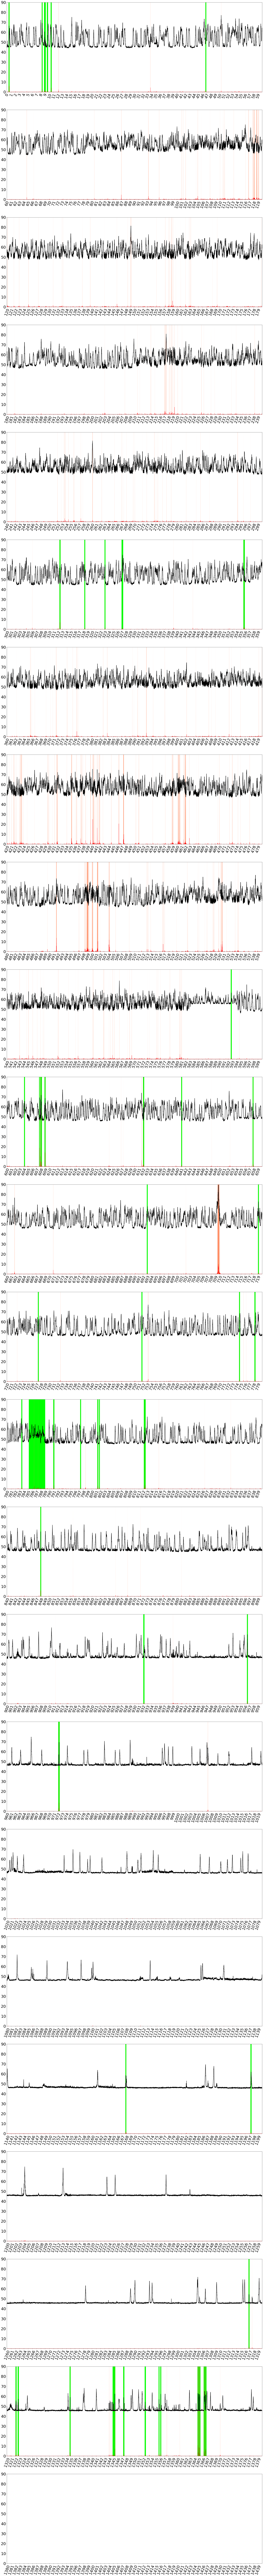

In [15]:
anorm=(d*5)**2
validate.figure(test_v, anorm, d, thr)